In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp

%matplotlib inline

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [296]:
# Get the positive mode data ~ 80 mb
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
project_path = 'revo_healthcare/data/processed/ST000578/ST000578_AN000888_Results.tsv'
data = pd.read_csv(local_path+project_path, sep='\t')

In [297]:
# Parse the class-labels from output
outcome = data.iloc[0,:]
print outcome.unique()
# convert all P. vivax into just P.vivax
susceptible_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Susceptible')]

resistant_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Resistant')]

print '\n\nSusceptible', susceptible_triplicate.shape[0] / 3
print 'Resistant', resistant_triplicate.shape[0] / 3

# Select one of the three triplicate samples
resistant = resistant_triplicate[~resistant_triplicate.index.str.contains('\.')]
susceptible = susceptible_triplicate[~susceptible_triplicate.index.str.contains('\.')]
print 'Resistant', resistant.values
# Relabel so that only two classes
resistant[:] = 'Chloroquine resistant'
susceptible[:] = 'Chloroquine susceptible'
print '\n\n Resistant', resistant
print '\n\n susceptible', susceptible
class_labels = pd.concat([resistant, susceptible])
print class_labels


['Factors'
 'Current Malaria Infection:None | Prior Malaria Infection:N/A | Chloroquine Resistance:N/A'
 'Current Malaria Infection:None | Prior Malaria Infection:NO | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:NO | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Susceptible'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:None | Prior Malaria Infection:YES | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:NO | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Resistant']


Susceptible 33
Resistant 31
Resistant [ 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | C

In [298]:
# Check other subsets of data
susceptible_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Susceptible')]

resistant_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Resistant')]

print susceptible_triplicate.unique()
print "Number susceptible", susceptible_triplicate.shape[0] / 3, '\n'
print resistant_triplicate.unique()
print "number resistant", resistant_triplicate.shape[0] /3
print 'num resistant, no prior malaria', resistant_triplicate.str.contains('NO').shape[0] / 3
print 'num resistant, no prior malaria', resistant_triplicate.str.contains('N\/A').shape[0] / 3
print resistant_triplicate.values

# 31 resistant
# 15 with n/a
# 15 with prior malaria
# 1 without prior malaria


[ 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Susceptible']
Number susceptible 33 

[ 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:NO | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Resistant']
number resistant 31
num resistant, no prior malaria 31
num resistant, no prior malaria 31
[ 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YE

In [299]:
def remove_zero_columns(X, threshold=1e-20):
    '''
    Requires dataframe
    '''
    # convert zeros to nan, drop all nan columns, the replace leftover nan with zeros
    X_non_zero_colum = X.replace(0, np.nan).dropna(how='all', axis=1).replace(np.nan, 0)
    #.dropna(how='all', axis=0).replace(np.nan,0)
    return X_non_zero_colum

def zero_fill_half_min(X, threshold=1e-20):
    # Fill zeros with 1/2 the minimum value of that column
    # input dataframe. Add only to zero values
    
    # Get a vector of 1/2 minimum values
    half_min = X[X > threshold].min(axis=0)*0.5
    
    # Add the half_min values to a dataframe where everything that isn't zero is NaN.
    # then convert NaN's to 0
    fill_vals = (X[X < threshold] + half_min).fillna(value=0)
    
    # Add the original dataframe to the dataframe of zeros and fill-values
    X_zeros_filled = X + fill_vals
    return X_zeros_filled

toy = pd.DataFrame([[1,2,3,0],
               [0,0,0,0],
               [0.5,1,0,0]], dtype=float)

toy_no_zeros = remove_zero_columns(toy)
toy_filled_zeros = zero_fill_half_min(toy_no_zeros)
print toy
print toy_no_zeros
print toy_filled_zeros

     0    1    2    3
0  1.0  2.0  3.0  0.0
1  0.0  0.0  0.0  0.0
2  0.5  1.0  0.0  0.0
     0    1    2
0  1.0  2.0  3.0
1  0.0  0.0  0.0
2  0.5  1.0  0.0
      0    1    2
0  1.00  2.0  3.0
1  0.25  0.5  1.5
2  0.50  1.0  1.5


In [336]:
# Grab samples that have correct class labels
df_raw = data[class_labels.index]
print df_raw.head()
raise he
# remove first column and convert to float
df_raw = df_raw.iloc[1:,:].astype('float64')
print "df_raw shape", df_raw.shape
print "class labels", class_labels.shape
# Make sure labels and df_raw-columns are in correct order
print "quick eyeball that y and X are in same order ", zip(df_raw.columns, class_labels.index)[0:5]
assert (df_raw.columns == class_labels.index).all()
print df_raw.head

# Conver to binary class labels
print class_labels.unique()
le = preprocessing.LabelEncoder()
le.fit(class_labels)
y = le.transform(class_labels)
print y

# Convert to numpy array
#X_raw = df_nonzero.as_matrix().T


                                             2009227  \
0  Current Malaria Infection:P.Vivax | Prior Mala...   
1                                        51065.03274   
2                                        34348.85255   
3                                        880363.6806   
4                                                  0   

                                             2008791  \
0  Current Malaria Infection:P.Vivax | Prior Mala...   
1                                        22154.69474   
2                                        49230.82536   
3                                        1057405.156   
4                                        125925.8035   

                                             2008700  \
0  Current Malaria Infection:P.Vivax | Prior Mala...   
1                                                  0   
2                                        70190.04916   
3                                        1362530.042   
4                                             

NameError: name 'he' is not defined

<h2> Time to preprocess feature table </h2>

In [301]:
# TODO PQN normalization, and log-transformation, 
# and some feature selection (above certain threshold of intensity, use principal components), et

def pqn_normalize(X, integral_first=False, plot=False):
    '''
    Take a feature table and run PQN normalization on it
    '''
    # normalize by sum of intensities in each sample first. Not necessary
    if integral_first: 
        sample_sums = np.sum(X, axis=1)
        X = (X / sample_sums[:,np.newaxis])
    
    # Get the median value of each feature across all samples
    mean_intensities = np.median(X, axis=0)
    print 'mean_intensity shape', mean_intensities.shape
    print 'Mean intensity', mean_intensities[0:10]
    # Divde each feature by the median value of each feature - 
    # these are the quotients for each feature
    X_quotients = (X / mean_intensities[np.newaxis,:])
    
    if plot: # plot the distribution of quotients from one sample
        for i in range(1,len(X_quotients[:,1])):
            print 'allquotients reshaped!\n\n', 
            #all_quotients = X_quotients.reshape(np.prod(X_quotients.shape))
            all_quotients = X_quotients[i,:]
            print all_quotients.shape
            x = np.random.normal(loc=0, scale=1, size=len(all_quotients))
            sns.violinplot(all_quotients)
            plt.title("median val: %f\nMax val=%f" % (np.median(all_quotients), np.max(all_quotients)))
            plt.plot( title="median val: ")#%f" % np.median(all_quotients))
            plt.xlim([-0.5, 5])
            plt.show()

    # Define a quotient for each sample as the median of the feature-specific quotients
    # in that sample
    sample_quotients = np.median(X_quotients, axis=1)
    
    # Quotient normalize each samples
    X_pqn = X / sample_quotients[:,np.newaxis]
    return X_pqn

# Make a fake sample, with 2 samples at 1x and 2x dilutions
X_toy = np.array([[1,1,1,],
                  [2,2,2],
                  [3,6,9],
                  [6,12,18]], dtype=float)
print X_toy
print X_toy.reshape(1, np.prod(X_toy.shape))
X_toy_pqn_int = pqn_normalize(X_toy, integral_first=True)
print X_toy_pqn_int

print '\n\n\n'
X_toy_pqn = pqn_normalize(X_toy)
print X_toy_pqn

[[  1.   1.   1.]
 [  2.   2.   2.]
 [  3.   6.   9.]
 [  6.  12.  18.]]
[[  1.   1.   1.   2.   2.   2.   3.   6.   9.   6.  12.  18.]]
mean_intensity shape (3,)
Mean intensity [ 0.25        0.33333333  0.41666667]
[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.16666667  0.33333333  0.5       ]]




mean_intensity shape (3,)
Mean intensity [ 2.5  4.   5.5]
[[ 4.  4.  4.]
 [ 4.  4.  4.]
 [ 2.  4.  6.]
 [ 2.  4.  6.]]


In [302]:
def prevalence_threshold(X, threshold=0.5):
    '''
    input: numpy matrix
    output matrix, but with columns where presence/absence below threshold removed'''
    samples_present = (X > 1e-20).sum(axis=0)
    percent = np.divide(samples_present, float(X.shape[0]))
    print percent
    above_threshold = percent > threshold
    print above_threshold
    # only keep values b
    output = X[:,above_threshold]
    return output
    
test = np.array([[1,2,3], [0,0,3], [0,2,3]])
print 'Input\n', test
prevalence_threshold(test)

Input
[[1 2 3]
 [0 0 3]
 [0 2 3]]
[ 0.33333333  0.66666667  1.        ]
[False  True  True]


array([[2, 3],
       [0, 3],
       [2, 3]])

In [303]:
# preprocess feature table

# remove zero features
df_nonzero = remove_zero_columns(df_raw.T)
print 'Zero full shape', df_raw.T.shape
print 'Zeros removed shape', df_nonzero.shape
X_nonzero = df_nonzero.as_matrix()
print X_nonzero.shape


# standardize input
X_scaled = preprocessing.scale(X_nonzero)
print 'scaled mean', X_scaled.mean(axis=0)
print 'scaled std', X_scaled.std(axis=0)
print X_scaled[0:4]
# require feature to be present in at least 50% of samples
X_50percent = prevalence_threshold(X_nonzero, threshold=0.5)
print "50% prevalence cutoff", X_50percent.shape

X_80 = prevalence_threshold(X_nonzero, threshold=0.8)
print "80% prevalence cutoff", X_80.shape
# PQN normalize?
#print X_nonzero[0:5]
#X_pqn = pqn_normalize(X_nonzero)
#print X_pqn
# Final decision to use


Zero full shape (64, 20347)
Zeros removed shape (64, 18041)
(64, 18041)
scaled mean [ -2.77555756e-17  -2.08166817e-17  -6.93889390e-17 ...,  -5.55111512e-17
  -2.08166817e-17   2.60208521e-17]
scaled std [ 1.  1.  1. ...,  1.  1.  1.]
[[-0.22015996 -0.67058828 -1.04242515 ..., -0.81946284 -0.50490175
  -0.76044203]
 [-0.51361324 -0.27116883 -0.59282246 ..., -0.17879717 -0.3860976
   0.07657816]
 [-0.73849362  0.29135884  0.1820523  ...,  0.17456447 -0.50490175
   0.0765257 ]
 [-0.4743364  -0.62082992 -0.22046986 ...,  0.23829698 -0.50490175
  -0.57318127]]
[ 0.75      0.953125  0.984375 ...,  0.640625  0.34375   0.578125]
[ True  True  True ...,  True False  True]
50% prevalence cutoff (64, 4541)
[ 0.75      0.953125  0.984375 ...,  0.640625  0.34375   0.578125]
[False  True  True ..., False False False]
80% prevalence cutoff (64, 2103)


<h2> Define Random forest function <h/2>
TODO: turn this into a pipeline, silly

In [133]:
def roc_curve_cv(X, y, clf, cross_val,
                path='/home/irockafe/Desktop/roc.pdf',
                save=False, plot=True):  
    t1 = time.time()
    # collect vals for the ROC curves
    tpr_list = []
    mean_fpr = np.linspace(0,1,100)
    auc_list = []
    
    # Get the false-positive and true-positive rate
    for i, (train, test) in enumerate(cross_val):
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[test])[:,1]
        
        # get fpr, tpr
        fpr, tpr, thresholds = roc_curve(y[test], y_pred)
        roc_auc = auc(fpr, tpr)
        #print 'AUC', roc_auc
        #sns.plt.plot(fpr, tpr, lw=10, alpha=0.6, label='ROC - AUC = %0.2f' % roc_auc,)
        #sns.plt.show()
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        tpr_list[-1][0] = 0.0
        auc_list.append(roc_auc)
        
        if (i % 10 == 0):
            print '{perc}% done! {time}s elapsed'.format(perc=100*float(i)/cross_val.n_iter, time=(time.time() - t1))
        
            
        
        
    # get mean tpr and fpr
    mean_tpr = np.mean(tpr_list, axis=0)
    # make sure it ends up at 1.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_list)
    
    if plot:
        # plot mean auc
        plt.plot(mean_fpr, mean_tpr, label='Mean ROC - AUC = %0.2f $\pm$ %0.2f' % (mean_auc, 
                                                                                       std_auc),
                    lw=5, color='b')

        # plot luck-line
        plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                    label='Luck', alpha=0.5) 

        # plot 1-std
        std_tpr = np.std(tpr_list, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                            label=r'$\pm$ 1 stdev')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve, {iters} iterations of {cv} cross validation'.format(
            iters=cross_val.n_iter, cv='{train}:{test}'.format(test=cross_val.test_size, train=(1-cross_val.test_size)))
                 )
        plt.legend(loc="lower right")

        if save:
            plt.savefig(path,  format='pdf')


        plt.show()
    return tpr_list, auc_list, mean_fpr

25
0.3
0.0% done! 1.81439590454s elapsed
40.0% done! 20.7781660557s elapsed
80.0% done! 39.6885519028s elapsed


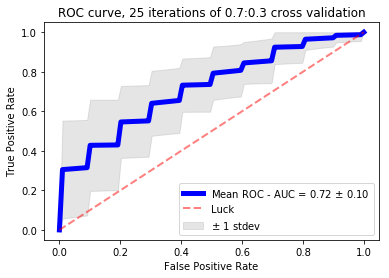

In [305]:


rf_estimators = 500
n_iter = 25
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

print cross_val_rf.n_iter
print cross_val_rf.test_size

# unscaled
tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_nonzero, y, clf_rf, cross_val_rf,
                                           save=False)

50
0.3
0.0% done! 6.23399305344s elapsed
20.0% done! 76.0771548748s elapsed
40.0% done! 142.417345047s elapsed
60.0% done! 208.340952873s elapsed
80.0% done! 272.890228987s elapsed


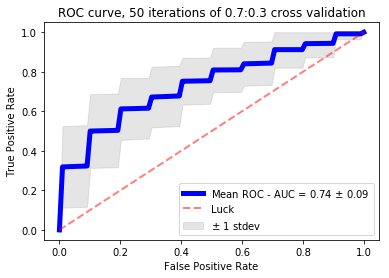

In [304]:
# what about with a bit of feature pruning?


rf_estimators = 2000
n_iter = 50
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

print cross_val_rf.n_iter
print cross_val_rf.test_size

# unscaled
tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_50percent, y, clf_rf, cross_val_rf,
                                           save=False)

25
0.3
0.0% done! 3.23655700684s elapsed
40.0% done! 35.9883110523s elapsed
80.0% done! 69.0458688736s elapsed


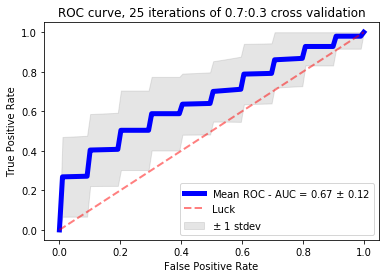

In [193]:
# what about with a bit of feature pruning?
rf_estimators = 1000
n_iter = 25
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

print cross_val_rf.n_iter
print cross_val_rf.test_size

# unscaled
tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_80, y, clf_rf, cross_val_rf,
                                           save=False)

<h2>Plot the mz/rt space </h2>

In [267]:
data = data.iloc[1:, :]
data = data.set_index(data.iloc[:,0])

def prevalence_threshold(df, threshold=0.5):
    '''
    features x samples df
    '''
    output = df[((df > 1e-20).sum(axis=1) / df.shape[1]) > threshold]
    return output

df_raw = data[class_labels.index]

#print df_raw.head
df_50percent_prevalence = prevalence_threshold(df_raw, threshold=0.5)
print df_50percent_prevalence.index

Index([u'89.5059_435.1', u'90.0074_371.2', u'90.0075_8.6', u'90.0076_439.3',
       u'90.0902_271.2', u'90.5060_435.3', u'90.5060_7.9', u'90.5060_556.1',
       u'90.5090_369.6', u'90.5092_17.6',
       ...
       u'1565.0444_430.9', u'1566.0391_432.0', u'1577.8963_418.0',
       u'1578.8915_418.4', u'1735.1634_417.2', u'1735.6551_417.7',
       u'1762.1148_417.4', u'1763.1075_417.3', u'1983.3337_417.2',
       u'1984.3186_417.5'],
      dtype='object', name=u'Samples', length=5151)


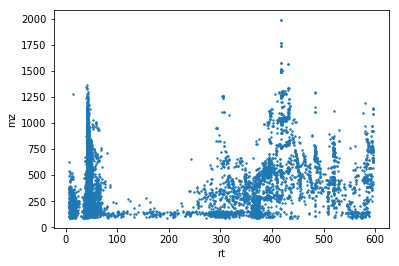

In [251]:
mz_rt_df = pd.DataFrame([i.split('_') for i in df_50percent_prevalence.index],
            columns=['mz', 'rt'], dtype='float64')

plt.scatter(x=mz_rt_df['rt'], y=mz_rt_df['mz'], s=2
           )
plt.xlabel('rt')
plt.ylabel('mz')
plt.show()

In [334]:
# Select between 350 and 350
df_slice = mz_rt_df[(mz_rt_df['rt'] > 350) & (mz_rt_df['rt'] < 475)]
print mz_rt_df.shape
print asdf.shape
print df_slice.shape

# convert df_slice into X and run rf on it
print 'df-slice', df_slice[-8:-1]
print df_slice.shape
print 'shape of x-50', X_nonzero.shape

(5155, 2)
(2923, 2)
(1390, 2)
df-slice              mz     rt
5147  1577.8963  418.0
5148  1578.8915  418.4
5149  1735.1634  417.2
5150  1735.6551  417.7
5151  1762.1148  417.4
5152  1763.1075  417.3
5153  1983.3337  417.2
(1390, 2)
shape of x-50 (64, 18041)


<h2> Try to back out the 22 patients that are repeats...? </h2>
Or just wait for Karan Uppal to give the info

In [338]:
# Get the positive mode data ~ 80 mb
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
project_path = 'revo_healthcare/data/processed/ST000578/ST000578_AN000888_Results.tsv'
data = pd.read_csv(local_path+project_path, sep='\t')

In [344]:
df_50percent_prevalence
mz_rt_df = pd.DataFrame([i.split('_') for i in df_50percent_prevalence.index],
            columns=['mz', 'rt'], dtype='float64',
                       index=df_50percent_prevalence.index)
mz_rt_df
df_50percent_prevalence_mzrt = pd.concat([mz_rt_df, df_50percent_prevalence],
                                        axis=1)
df_50percent_prevalence_mzrt

,mz,rt,2009227,2008791,2008700,2008675,2008630,2007260,2008235,2009263,...,2008654,2008627,2009254,2009225,2008722,2008702,2008660,2008628,2008618,2008621
Samples,,,,,,,,,,,,,,,,,,,,,
89.5059_435.1,89.5059,435.1,0,0,8257841.742,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90.0074_371.2,90.0074,371.2,10498841.66,9841835.671,9580520.612,10914163.22,9153719.487,10828925.47,11772214.82,10512799.3,...,7026674.414,7032003.049,7719911.028,7256920.416,8141573.982,7984498.671,9110181.769,10796345.17,8011757.469,6165551.241
90.0075_8.6,90.0075,8.6,3965161.294,2781320.516,1717467.517,4557703.401,3319942.933,2346799.773,16144.20002,3191167.455,...,3361374.609,3225108.739,3234679.55,2257954.805,2829996.817,3025325.917,3964125.1,3894615.297,3767459.37,1860727.982
90.0076_439.3,90.0076,439.3,0,0,1074652.702,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90.0902_271.2,90.0902,271.2,149087.1152,0,0,0,0,74752.09517,0,0,...,0,134253.2046,0,0,0,0,226999.9155,0,224761.5756,0
90.5060_435.3,90.5060,435.3,0,0,884390.5513,0,0,1974046.316,1700740.002,0,...,0,0,2882807.655,780882.399,0,0,0,1167876.502,0,0
90.5060_7.9,90.5060,7.9,6058519.493,2231072.165,423239.0544,3850227.892,5264008.161,4112418.498,2444736.853,5342918.932,...,6515632.634,0,4333684.698,3044488.261,0,3399020.112,4821618.007,6331004.895,6149395.473,4007774.961
90.5060_556.1,90.5060,556.1,0,0,4244221.354,4864197.202,0,4951916.472,4896935.91,1427984.56,...,0,2333475.243,1396999.005,0,4685815.578,4315130.185,1679274.02,3989390.666,0,0
90.5090_369.6,90.5090,369.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,125527.8799,238728.988,0,0,0


596.6
1984.3186
ymin:  39.5059


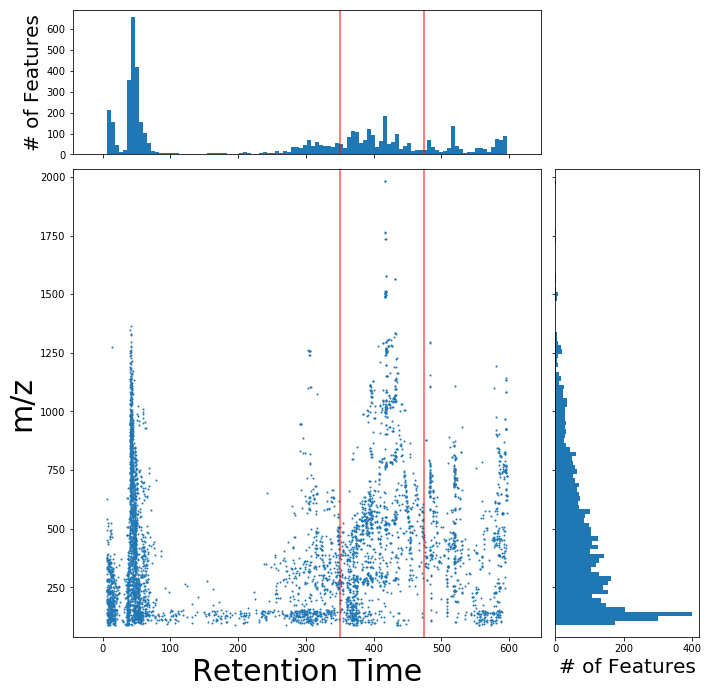

In [354]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

def get_rt_slice(df, rt_bounds):
    '''
    PURPOSE: 
        Given a tidy feature table with 'mz' and 'rt' column headers, 
        retain only the features whose rt is between rt_left 
        and rt_right
    INPUT: 
        df - a tidy pandas dataframe with 'mz' and 'rt' column 
            headers
        rt_left, rt_right: the boundaries of your rt_slice, in seconds
    '''
    out_df = df.loc[ (df['rt'] > rt_bounds[0]) & 
                    (df['rt'] < rt_bounds[1])]
    return out_df

def plot_mz_rt(df, rt_bounds, path='/home/irockafe/Desktop/poop.pdf'):
    # the random data
    x = df['rt']
    y = df['mz']
    print np.max(x)
    print np.max(y)
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    #fig = plt.figure(1, figsize=(8, 8))
    fig = plt.figure(1, figsize=(10,10))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y, s=1)

    # now determine nice limits by hand:
    binwidth = 0.25

    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])

    #lim = (int(xymax/binwidth) + 1) * binwidth

    x_min = np.min(x)-50
    x_max = np.max(x)+50
    axScatter.set_xlim(x_min, x_max )
    y_min = np.min(y)-50
    y_max = np.max(y)+50
    axScatter.set_ylim(y_min, y_max)

    # Add vertical red line between 750-1050 retention time
    '''
    plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                        label='Luck', alpha=0.5)
    '''
    print 'ymin: ', y_min
    # Add vertical/horizontal lines to scatter and histograms
    axScatter.axvline(x=rt_bounds[0], lw=2, color='r', alpha=0.5)
    axScatter.axvline(x=rt_bounds[1], lw=2, color='r', alpha=0.5)

    axHistx.axvline(x=rt_bounds[0], lw=2, color='r', alpha=0.5)
    axHistx.axvline(x=rt_bounds[1], lw=2, color='r', alpha=0.5)

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 100
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.set_ylabel('m/z', fontsize=30)
    axScatter.set_xlabel('Retention Time', fontsize=30)

    axHistx.set_ylabel('# of Features', fontsize=20)
    axHisty.set_xlabel('# of Features', fontsize=20)
        
    plt.savefig(path, 
                format='pdf')
    plt.show()


rt_slice = (350, 475)
df_50percent_slice = get_rt_slice(df_50percent_prevalence_mzrt, rt_slice)

# plot selection 
plot_mz_rt(df_50percent_prevalence_mzrt, (rt_slice))


slice shape (66, 2229)
25
0.3
0.0% done! 4.05469584465s elapsed
40.0% done! 37.6644158363s elapsed
80.0% done! 70.914978981s elapsed


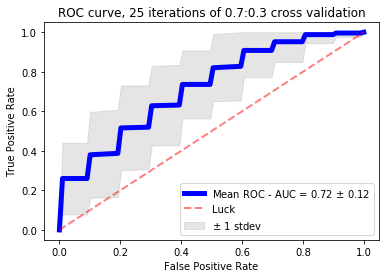

In [394]:
X_50_slice = df_50percent_slice.T.as_matrix()
print "slice shape", X_50_slice.shape



rf_estimators = 1000
n_iter = 25
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

print cross_val_rf.n_iter
print cross_val_rf.test_size

# unscaled
tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_50_slice, y, clf_rf, cross_val_rf,
                                           save=False)

<h2> Same story holds as before: By running only a subset of chromatography, you can still do just as well classifying </h2>

Try another subset of retention time

596.6
1984.3186
ymin:  39.5059


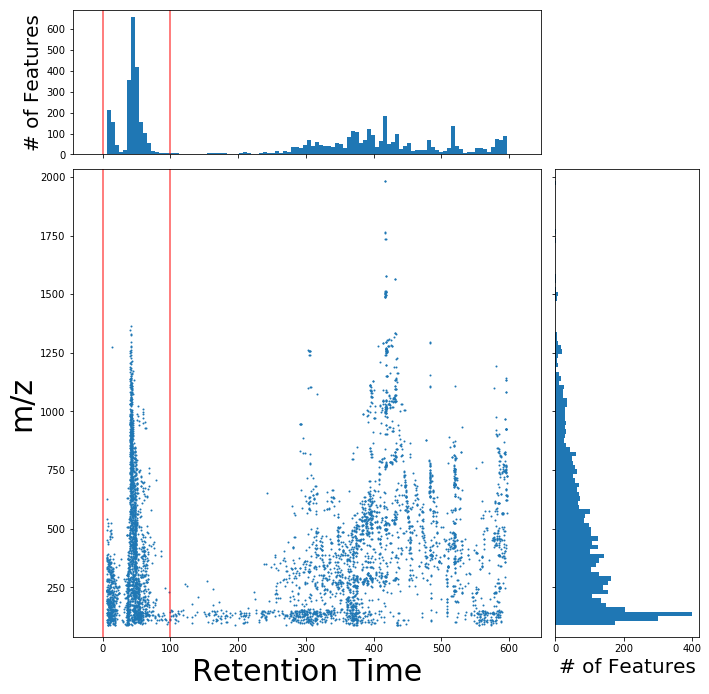

<bound method DataFrame.head of                     2009227      2008791      2008700      2008675  \
Samples                                                              
90.0075_8.6     3965161.294  2781320.516  1717467.517  4557703.401   
90.5060_7.9     6058519.493  2231072.165  423239.0544  3850227.892   
90.5092_17.6              0  115455.5355            0            0   
90.5249_36.0    5448438.699  7198422.653  9807786.115  6275756.742   
90.9756_43.2    5969641.319  7682736.664  6454374.441  5167697.656   
91.0077_10.9    350121.5799  280759.0341  265857.4427  350320.5165   
91.0225_34.9    414013.9793            0  951154.1525  621837.0755   
91.0266_36.8     323496.014  419842.6729  600436.0097  393878.3168   
91.5011_18.2              0            0            0            0   
91.5037_8.1     2113778.491   1035747.08  596398.0602  1648143.578   
91.9790_41.8              0            0            0            0   
92.0389_37.6              0            0            0     

0.0% done! 4.78106617928s elapsed


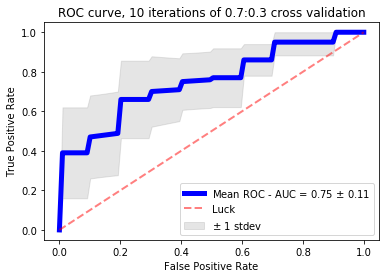

In [401]:
def slice_and_predict(df, y, rt_slice,
                     rf_estimators=1000, 
                     n_iter=10, test_size=0.3, random_state=1):
    df_slice = get_rt_slice(df, rt_slice)

    # plot selection 
    plot_mz_rt(df, (rt_slice))
    # remove mz and rt from dataframe...
    df_slice_no_mzrt = df_slice.drop(['mz', 'rt'], axis=1)
    X_slice = df_slice_no_mzrt.T.as_matrix()
    print "slice shape", X_slice.shape

    # Run RF
    rf_estimators = rf_estimators
    n_iter = n_iter
    test_size = test_size
    random_state = random_state
    cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
    clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)
    tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_slice, y, clf_rf, cross_val_rf,
                                               save=False)


rt_slice = (0,100)
df_50percent_prevalence_mzrt
#df_50percent_prevalence_mzrt.drop(['mz', 'rt'], axis=1)
slice_and_predict(df_50percent_prevalence_mzrt, y, rt_slice)

In [388]:
def make_sliding_window(min_val, max_val, width, step):
    '''
    Width should be
    '''
    if step > width:
        raise ValueError, ("Your step should be less than"+
                           "or equal to the width of the window")
    left_bound = np.arange(min_val, max_val, step)
    right_bound = left_bound + width
    rt_bounds = zip(left_bound, right_bound)
    # remove any bounds that go past the maximum value
    for idx, i in enumerate(rt_bounds):
        if i[1] > max_val:
            rt_bounds.pop(idx)
    return rt_bounds

make_sliding_window(0, 100, 10, 5)



[(0, 10),
 (5, 15),
 (10, 20),
 (15, 25),
 (20, 30),
 (25, 35),
 (30, 40),
 (35, 45),
 (40, 50),
 (45, 55),
 (50, 60),
 (55, 65),
 (60, 70),
 (65, 75),
 (70, 80),
 (75, 85),
 (80, 90),
 (85, 95),
 (90, 100)]

min: 0, max: 596.6, width: 119.32, step: 59.66
(0.0, 119.32000000000001)
596.6
1984.3186
ymin:  39.5059


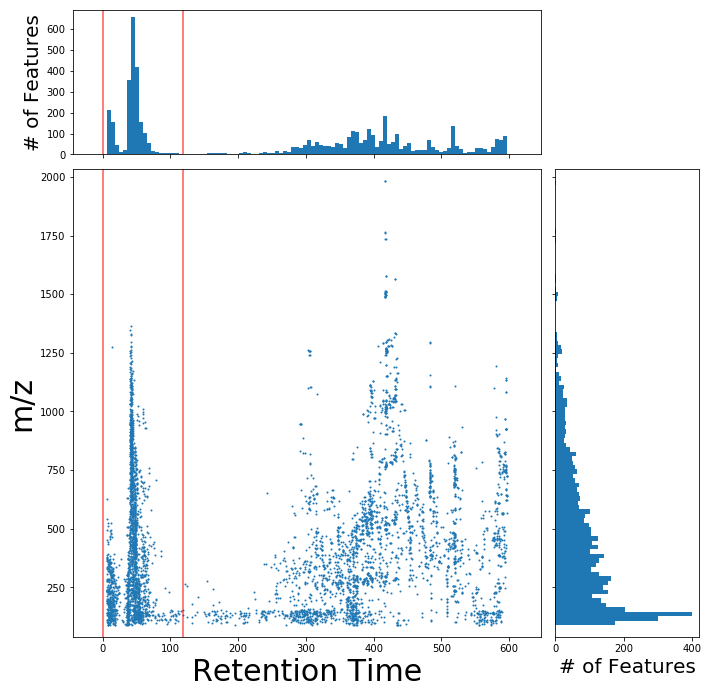

slice shape (66, 2248)
0.0% done! 3.12874293327s elapsed
40.0% done! 38.1319730282s elapsed
80.0% done! 74.1431500912s elapsed


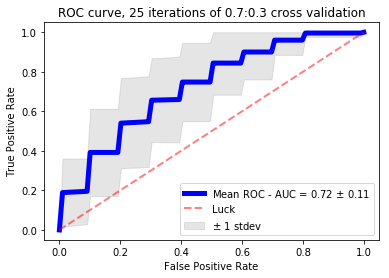




--------------------------------------------------NEXT ROUND--------------------------------------------------



(59.660000000000004, 178.98000000000002)
596.6
1984.3186
ymin:  39.5059


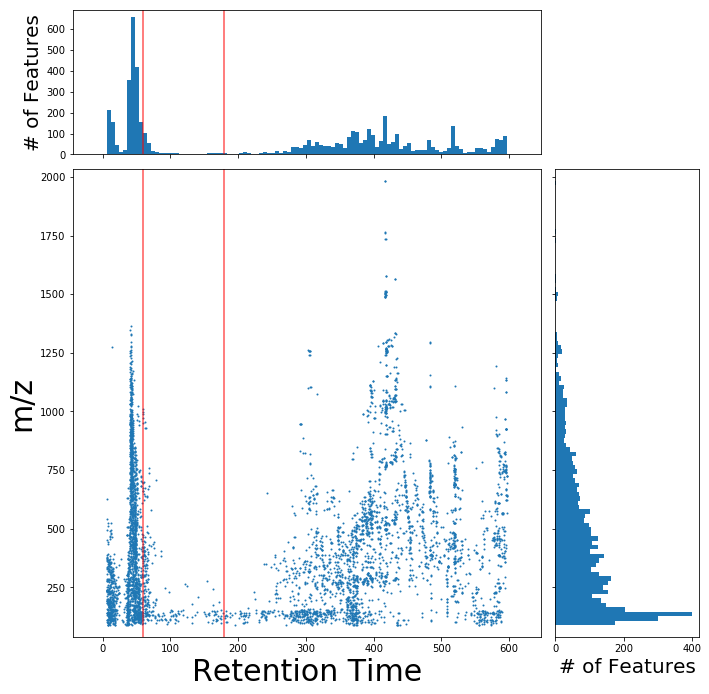

slice shape (66, 243)
0.0% done! 4.19101309776s elapsed
40.0% done! 38.577999115s elapsed
80.0% done! 74.5704450607s elapsed


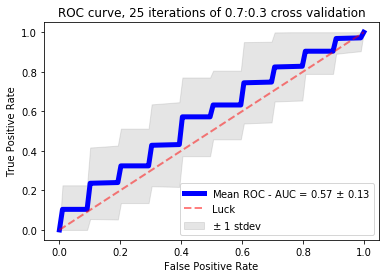




--------------------------------------------------NEXT ROUND--------------------------------------------------



(119.32000000000001, 238.64000000000001)
596.6
1984.3186
ymin:  39.5059


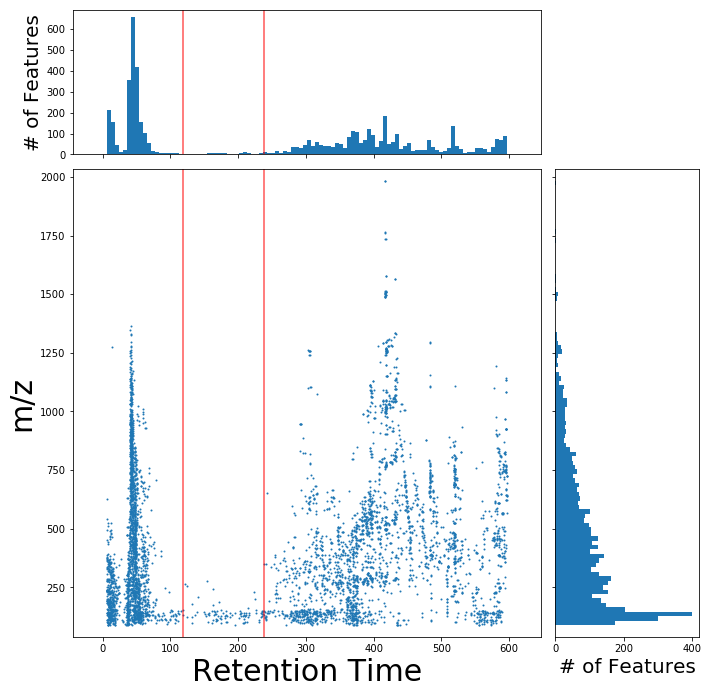

slice shape (66, 91)
0.0% done! 3.03325486183s elapsed
40.0% done! 33.2707278728s elapsed
80.0% done! 62.8525710106s elapsed


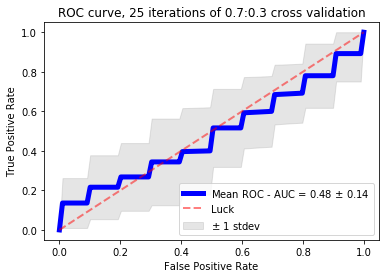




--------------------------------------------------NEXT ROUND--------------------------------------------------



(178.98000000000002, 298.30000000000001)
596.6
1984.3186
ymin:  39.5059


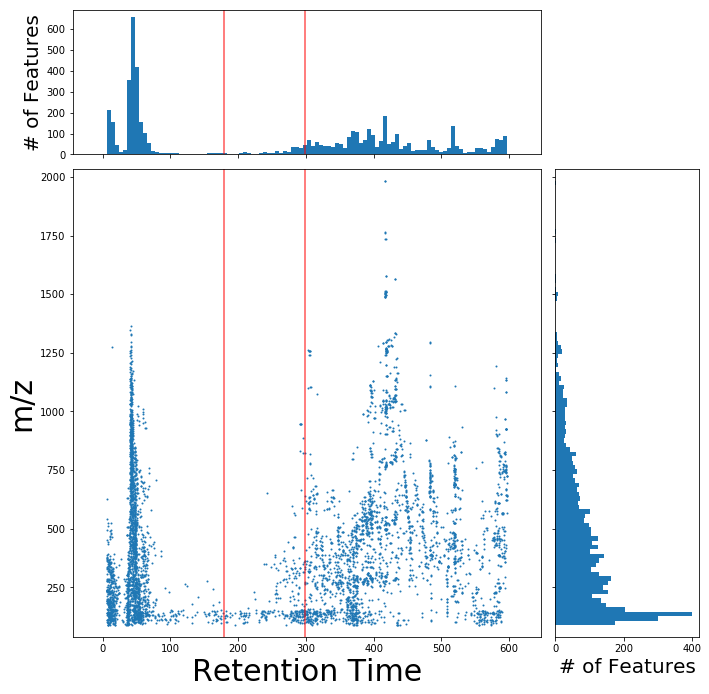

slice shape (66, 245)
0.0% done! 3.43220806122s elapsed
40.0% done! 31.9505441189s elapsed
80.0% done! 60.5420660973s elapsed


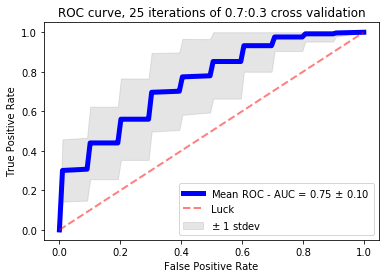




--------------------------------------------------NEXT ROUND--------------------------------------------------



(238.64000000000001, 357.96000000000004)
596.6
1984.3186
ymin:  39.5059


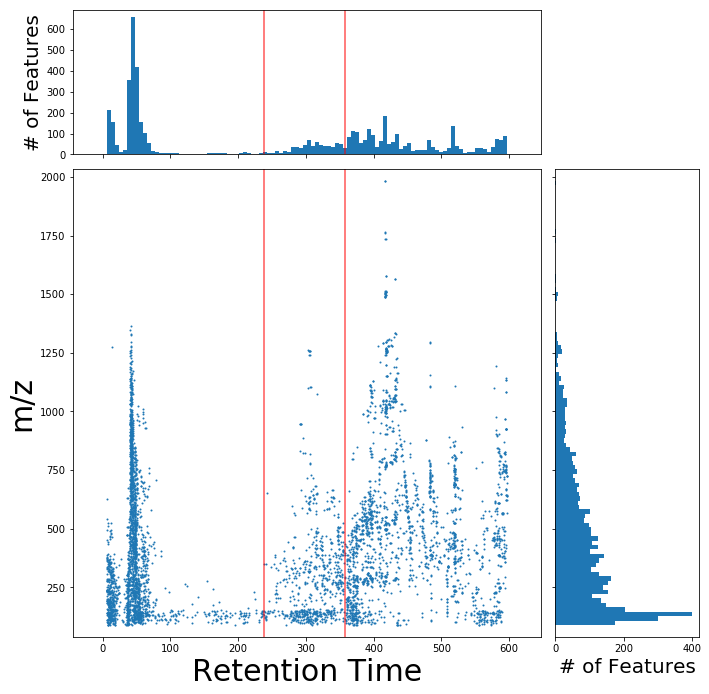

slice shape (66, 672)
0.0% done! 3.0954041481s elapsed
40.0% done! 32.2163431644s elapsed
80.0% done! 61.3447351456s elapsed


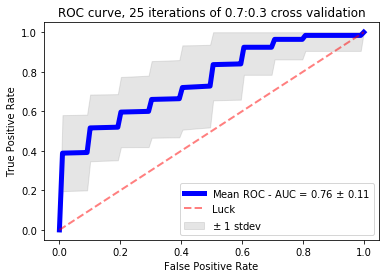




--------------------------------------------------NEXT ROUND--------------------------------------------------



(298.30000000000001, 417.62)
596.6
1984.3186
ymin:  39.5059


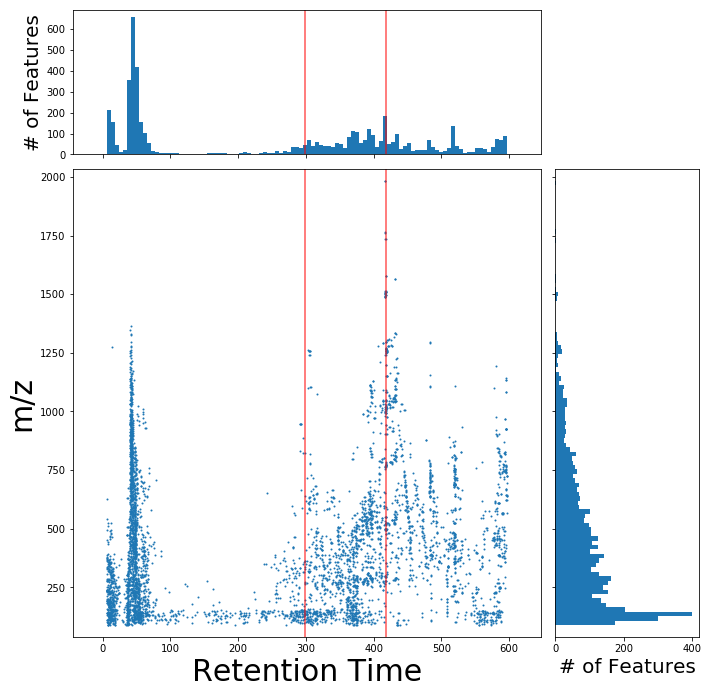

slice shape (66, 1314)
0.0% done! 3.45354104042s elapsed
40.0% done! 33.3407568932s elapsed
80.0% done! 63.2684009075s elapsed


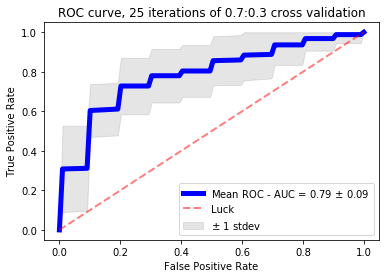




--------------------------------------------------NEXT ROUND--------------------------------------------------



(357.96000000000004, 477.28000000000003)
596.6
1984.3186
ymin:  39.5059


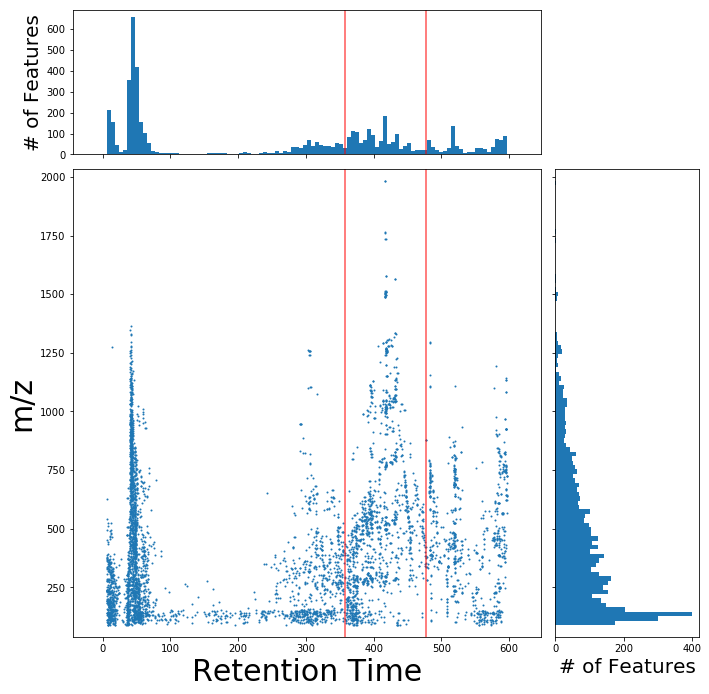

slice shape (66, 1346)
0.0% done! 3.14566516876s elapsed
40.0% done! 34.858104229s elapsed
80.0% done! 69.7666180134s elapsed


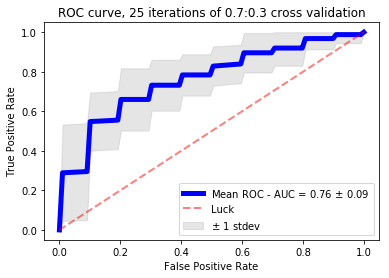




--------------------------------------------------NEXT ROUND--------------------------------------------------



(417.62, 536.94000000000005)
596.6
1984.3186
ymin:  39.5059


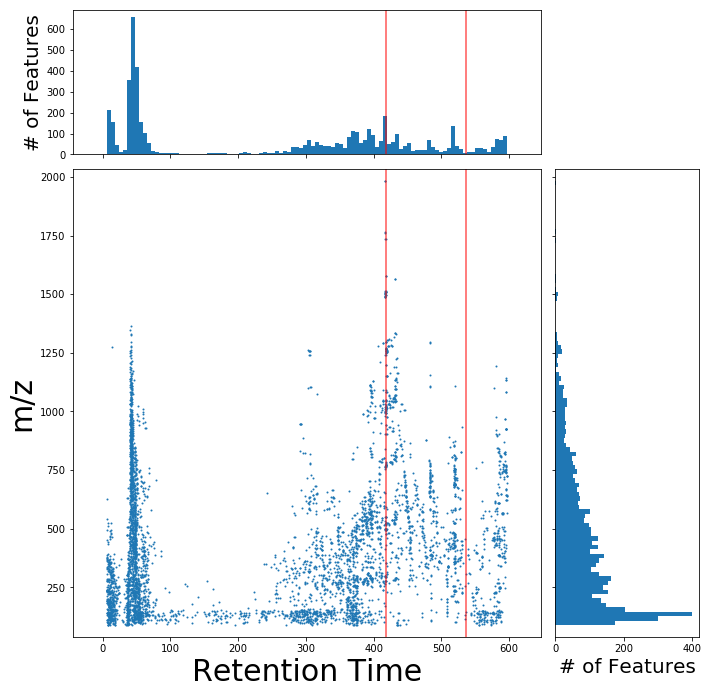

slice shape (66, 919)
0.0% done! 4.22216081619s elapsed
40.0% done! 39.1709859371s elapsed
80.0% done! 76.0188238621s elapsed


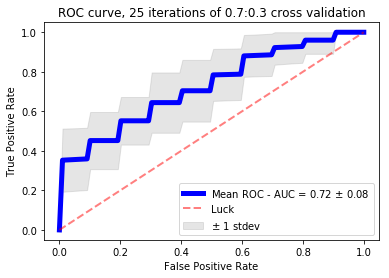




--------------------------------------------------NEXT ROUND--------------------------------------------------



(477.28000000000003, 596.60000000000002)
596.6
1984.3186
ymin:  39.5059


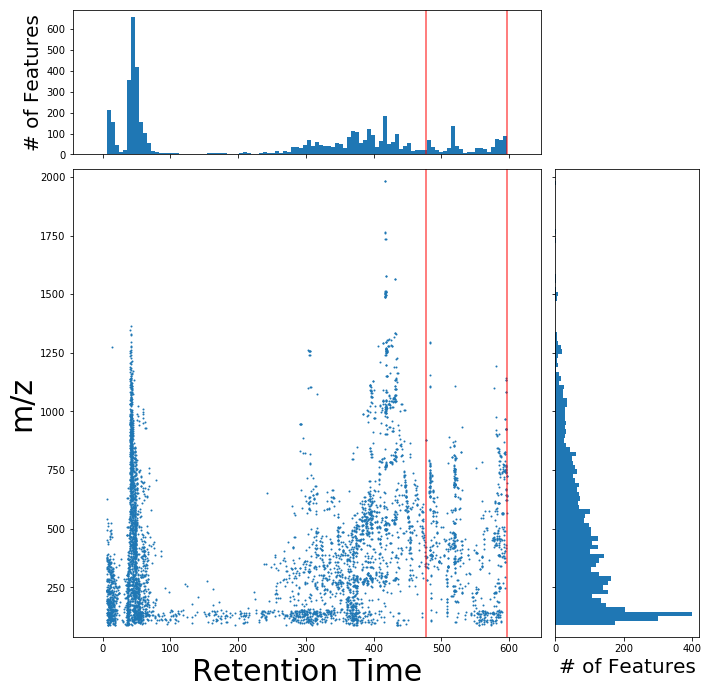

slice shape (66, 793)
0.0% done! 4.71782708168s elapsed
40.0% done! 52.1401121616s elapsed
80.0% done! 85.8386499882s elapsed


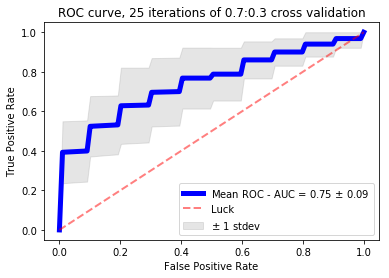




--------------------------------------------------NEXT ROUND--------------------------------------------------





In [396]:
# Make sliding window
min_val = 0
max_val = df_50percent_prevalence_mzrt['rt'].max()
width = max_val / 5.0
step = width / 2
print "min: {mini}, max: {maxi}, width: {width}, step: {step}".format(
        mini=min_val, maxi=max_val, width=width, step=step)
sliding_window = make_sliding_window(min_val, max_val, width, step)

# plot and run classifier on sliding window
for rt_slice in sliding_window:
    print rt_slice
    slice_and_predict(df_50percent_prevalence_mzrt, y, rt_slice,
                      rf_estimators=1000, 
                     n_iter=25, test_size=0.3, random_state=1)
    print '\n\n\n'+'-'*50+'NEXT ROUND'+'-'*50+'\n\n\n'